<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/new_transfer_learning_with_stratifiedKFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess
import shutil
import copy
import statistics as st
from scipy import stats

from imutils import rotate as rotate
# import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
#from livelossplot import PlotLossesKeras

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import PReLU, ReLU, LeakyReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D 
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=DeprecationWarning)

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 31.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.5 MB/s 


In [6]:
!unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

Archive:  gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating

In [7]:
random_state = 1234

In [ ]:
def build_pretained_model(model_name):
    """
    This function utilizes transfer learning of a given model.
    """
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    tf.keras.backend.clear_session()
    input_shape = (image_size, image_size, 3)
    if model_name == 'VGG19':
        pretrained_model = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'DenseNet201':
        pretrained_model = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'ResNet50':
        pretrained_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'VGG16':
        pretrained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'EfficientNetB7':
        pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'MobileNet':
        pretrained_model = tf.keras.applications.MobileNet(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'Xception':
        pretrained_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'InceptionV3':
        pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif model_name == 'ResNet152V2':
        pretrained_model = ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')   # New Addition by Heesuk
    return pretrained_model

In [ ]:
# pretrained_model = build_pretained_model(model_name = model_name)
# pretrained_model.trainable = False
        
# # Plug the pre-trained model to custom model
# print(f"Plugging in the pretainined model for {model_name} to custom model")
# try:
#     del model
# except:
#     None
# input_shape = (image_size, image_size, 3)
# inputs = tf.keras.Input(input_shape)
# m2 = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model(inputs))
# m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
# m2 = tf.keras.layers.Dense(512, activation = 'relu')(m2)
# m2 = tf.keras.layers.BatchNormalization()(m2)
# m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
# m2 = tf.keras.layers.Dense(256, activation = 'relu')(m2)
# m2 = tf.keras.layers.BatchNormalization()(m2)
# m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
# m2 = tf.keras.layers.Flatten()(m2)
# m2 = tf.keras.layers.Dense(1, activation = None)(m2)
# model = tf.keras.Model(inputs = inputs, outputs = m2)

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
!unzip -o -qq \*.zip  && rm *.zip


unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
!rm -rf image_processing/

In [ ]:
!ls -ltr Dataset

total 12
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Test
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Train
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Validate


In [ ]:
!ls -ltr Dataset/Train/0|wc -l
!ls -ltr Dataset/Train/1|wc -l

!ls -ltr Dataset/Test/0|wc -l
!ls -ltr Dataset/Test/1|wc -l

!ls -ltr Dataset/Validate/0|wc -l
!ls -ltr Dataset/Validate/1|wc -l

401
401
101
101
101
101


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img


from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *  
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import ReLU, LeakyReLU

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')


In [ ]:
val_image_directory = '/content/Dataset/Validate'
train_image_directory = '/content/Dataset/Train'
test_image_directory = '/content/Dataset/Test'
directory_path = '/content/Dataset'

tgt_directory_path = '/content/image_processing'
tgt_train_positive_image_path = '/content/image_processing/train/positive/'
tgt_train_negative_image_path = '/content/image_processing/train/negative/'
tgt_val_positive_image_path = '/content/image_processing/val/positive/'
tgt_val_negative_image_path = '/content/image_processing/val/negative/'
tgt_test_positive_image_path = '/content/image_processing/test/positive/'
tgt_test_negative_image_path = '/content/image_processing/test/negative/'

tgt_path_list = [tgt_train_positive_image_path, tgt_train_negative_image_path,
                 tgt_val_positive_image_path, tgt_val_negative_image_path,
                 tgt_test_positive_image_path, tgt_test_negative_image_path
                ]

In [ ]:
train_positive_images_path = [train_image_directory + '/' +  dir + '/' for dir in os.listdir(train_image_directory) if dir != '.DS_Store'][0]
train_negative_images_path = [train_image_directory + '/' +  dir + '/' for dir in os.listdir(train_image_directory) if dir != '.DS_Store'][1]

test_positive_images_path = [test_image_directory + '/' +  dir + '/' for dir in os.listdir(test_image_directory) if dir != '.DS_Store'][0]
test_negative_images_path = [test_image_directory + '/' +  dir + '/' for dir in os.listdir(test_image_directory) if dir != '.DS_Store'][1]

val_positive_images_path = [val_image_directory + '/' +  dir + '/' for dir in os.listdir(val_image_directory) if dir != '.DS_Store'][0]
val_negative_images_path = [val_image_directory + '/' +  dir + '/' for dir in os.listdir(val_image_directory) if dir != '.DS_Store'][1]

In [ ]:
train_positive_images_path, train_negative_images_path

('/content/Dataset/Train/0/', '/content/Dataset/Train/1/')

In [ ]:
train_positive_images_list = [train_positive_images_path + file for file in list(os.walk(train_positive_images_path))[0][2] if file[0] != '.']
train_negative_images_list = [train_negative_images_path + file for file in list(os.walk(train_negative_images_path))[0][2] if file[0] != '.']

test_positive_images_list = [test_positive_images_path + file for file in list(os.walk(test_positive_images_path))[0][2] if file[0] != '.']
test_negative_images_list = [test_negative_images_path + file for file in list(os.walk(test_negative_images_path))[0][2] if file[0] != '.']

val_positive_images_list = [val_positive_images_path + file for file in list(os.walk(val_positive_images_path))[0][2] if file[0] != '.']
val_negative_images_list = [val_negative_images_path + file for file in list(os.walk(val_negative_images_path))[0][2] if file[0] != '.']

In [ ]:
len(train_positive_images_list + train_negative_images_list + test_positive_images_list + test_negative_images_list + val_positive_images_list + val_negative_images_list)

1200

In [ ]:
len(train_positive_images_list), len(train_negative_images_list), len(test_positive_images_list), len(test_negative_images_list), len(val_positive_images_list), len(val_negative_images_list)

(400, 400, 100, 100, 100, 100)

In [ ]:
test_img = load_img(train_positive_images_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)
print(type(test_img))
print(test_img.format)
print(test_img.mode)
print(test_img.size)
print(test_img.getbands())
print(test_img_arry.shape)
print("****")
test_img1 = load_img(train_positive_images_list[0])
test_img1_arry = img_to_array(test_img1)
print(test_img1_arry.shape)
print(test_img1.getbands())

<class 'PIL.Image.Image'>
None
L
(50, 50)
('L',)
(50, 50, 1)
****
(50, 50, 3)
('R', 'G', 'B')


In [ ]:
odd_file_list = []
def find_odd_shaped_files(file_list, file_size = 50):
    for file_name in file_list:
        test_img = load_img(file_name, color_mode ="grayscale")
        test_img_arry = img_to_array(test_img)
        if test_img_arry.shape[0] != file_size or test_img_arry.shape[1] != file_size:
            odd_file_list.append(file_name)

In [ ]:
find_odd_shaped_files(train_positive_images_list + train_negative_images_list + test_positive_images_list + test_negative_images_list + val_positive_images_list + val_negative_images_list)

In [ ]:
odd_file_list

['/content/Dataset/Train/0/9347_idx5_x2101_y801_class0.png',
 '/content/Dataset/Train/0/12954_idx5_x1651_y2951_class0.png',
 '/content/Dataset/Train/0/13106_idx5_x1_y2951_class0.png',
 '/content/Dataset/Test/0/13404_idx5_x1101_y2901_class0.png',
 '/content/Dataset/Validate/0/9320_idx5_x801_y2951_class0.png',
 '/content/Dataset/Validate/0/13694_idx5_x1551_y2801_class0.png',
 '/content/Dataset/Validate/0/12931_idx5_x1901_y2151_class0.png']

In [ ]:
train_negative_images_list[:5]

['/content/Dataset/Train/1/14190_idx5_x1051_y1101_class1.png',
 '/content/Dataset/Train/1/9250_idx5_x1201_y1701_class1.png',
 '/content/Dataset/Train/1/12823_idx5_x2751_y851_class1.png',
 '/content/Dataset/Train/1/12910_idx5_x901_y251_class1.png',
 '/content/Dataset/Train/1/12935_idx5_x1701_y1951_class1.png']

In [ ]:
train_positive_images_list[0].split("/")[-1], train_positive_images_list[0][:train_positive_images_list[0].rfind("/") + 1]

('10302_idx5_x501_y1701_class0.png', '/content/Dataset/Train/0/')

In [ ]:
image_file_extension = '.png'
root_dir = 'image_processing'

train_file_positive_gs_list = []
train_file_negative_gs_list = []

val_file_positive_gs_list = []
val_file_negative_gs_list = []

test_file_positive_gs_list = []
test_file_negative_gs_list = []

In [ ]:
os.makedirs(f'{root_dir}', exist_ok = True)
for dir in ['train', 'val', 'test']:
    for sub_dir in ['positive', 'negative']:
        os.makedirs(f'{root_dir}/{dir}/{sub_dir}', exist_ok=True)

In [ ]:
def create_gs_files(file_list, dest_dir, ind):
    #print(file_list, dest_dir, ind)
    for image_file in file_list:
        #print(image_file)
        if image_file[0] == '.' or image_file in odd_file_list:
            continue
        img_gs = load_img(image_file, color_mode = "grayscale")
        img_array_gs = img_to_array(img_gs)
        file_name = image_file.split("/")[-1]
        save_img(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension, img_array_gs)
        if ind == 1:
            train_file_positive_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
        elif ind == 2:
            train_file_negative_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
        elif ind == 3:
            val_file_positive_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
        elif ind == 4:
            val_file_negative_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
        elif ind == 5:
            test_file_positive_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
        elif ind == 6:
            test_file_negative_gs_list.append(dest_dir + file_name.split(".")[0] + '_gs' + image_file_extension)
                

In [ ]:
len(os.listdir('/content/Dataset/Validate/0'))

101

In [ ]:
create_gs_files(train_positive_images_list, tgt_train_positive_image_path, 1)
print(len(os.listdir('/content/Dataset/Train/1')))
print(len(os.listdir(tgt_train_positive_image_path)))
create_gs_files(train_negative_images_list, tgt_train_negative_image_path, 2)
len(os.listdir('/content/Dataset/Train/0'))
print(len(os.listdir(tgt_train_negative_image_path)))

create_gs_files(val_positive_images_list, tgt_val_positive_image_path, 3)
len(os.listdir('/content/Dataset/Validate/1'))
print(len(os.listdir(tgt_val_positive_image_path)))
create_gs_files(val_negative_images_list, tgt_val_negative_image_path, 4)
len(os.listdir('/content/Dataset/Validate/0'))
print(len(os.listdir(tgt_val_negative_image_path)))

create_gs_files(test_positive_images_list, tgt_test_positive_image_path, 5)
len(os.listdir('/content/Dataset/Test/1'))
print(len(os.listdir(tgt_test_positive_image_path)))
create_gs_files(test_negative_images_list, tgt_test_negative_image_path, 6)
len(os.listdir('/content/Dataset/Test/0'))
print(len(os.listdir(tgt_test_negative_image_path)))

401
397
400
97
100
99
100


In [ ]:
!ls -ltr /content/Dataset/Train/1/*.png|wc -l

400


In [ ]:
!ls -ltra /content/image_processing/train/positive/*.png|wc -l

397


In [ ]:
def custom_augmentation(np_tensor):
 
    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.5, 2)
 
    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.5)
 
    def random_saturation(np_tensor):
        return tf.image.random_saturation(np_tensor, 0.2, 3)
 
    def gaussian_noise(np_tensor):
        mean = 0
        # variance: randomly between 1 to 25
        var = np.random.randint(1, 26)
        # sigma is square root of the variance value
        noise = np.random.normal(mean,var**0.5,np_tensor.shape)
        return np.clip(np_tensor + noise, 0, 255).astype('int')

    augmnted_tensor = random_contrast(np_tensor)
    augmnted_tensor = random_hue(augmnted_tensor)
    augmnted_tensor = random_saturation(augmnted_tensor)
    augmented_tensor = gaussian_noise(augmnted_tensor)
  
    return np.array(augmnted_tensor)

# Train data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center            = True, 
    #featurewise_std_normalization = True,
    rescale                       = 1.0/255,
    horizontal_flip               = True, 
    vertical_flip                 = True, 
    #zca_whitening                 = random.choice([True, False]), 
    zoom_range                    = [0.8, 1.25],
    rotation_range                = 90,
    width_shift_range             = 0.30, 
    height_shift_range            = 0.30,
    shear_range                   = 45, 
    brightness_range              = [.3, 1.2],
    preprocessing_function        = custom_augmentation     
)

# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     #featurewise_center            = True, 
#     #featurewise_std_normalization = True,
#     rescale                       = 1.0/255)

# Validation data generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center            = True, 
    #featurewise_std_normalization = True
    rescale = 1.0/255
    )

# Test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center            = True, 
    #featurewise_std_normalization = True
    rescale = 1.0/255
    )

In [ ]:
'''
    horizontal_flip               = True, 
    vertical_flip                 = True, 
    #zca_whitening                 = random.choice([True, False]), 
    zoom_range                    = [0.8, 1.25],
    rotation_range                = 90,
    width_shift_range             = 0.30, 
    height_shift_range            = 0.30,
    shear_range                   = 45, 
    brightness_range              = [.3, 1.2]
    preprocessing_function        = custom_augmentation 
    '''

'\n    horizontal_flip               = True, \n    vertical_flip                 = True, \n    #zca_whitening                 = random.choice([True, False]), \n    zoom_range                    = [0.8, 1.25],\n    rotation_range                = 90,\n    width_shift_range             = 0.30, \n    height_shift_range            = 0.30,\n    shear_range                   = 45, \n    brightness_range              = [.3, 1.2]\n    preprocessing_function        = custom_augmentation \n    '

In [ ]:
model_name = 'DenseNet201'
# image_size = 50
image_size = 75        # for InceptionV3
dropout_rate = .5
batch_size = 32
lr_val = .001
epochs = 10

# image_size = 50
# transfer_learning_model_list = ['VGG16', 
#                                 'VGG19', 
#                                 'DenseNet201', 
#                                 'InceptionV3', 
#                                 'ResNet50', 
#                                 'EfficientNetB7', 
#                                 'MobileNet', 
#                                 'Xception',
                                # 'ResNet152V2'
#                                ]

In [ ]:
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation

In [ ]:
# model_cnn_5 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu,
#                            input_shape=(50, 50, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),
#     tf.keras.layers.Dropout(.1),

#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),
#     tf.keras.layers.Dropout(.1),

#     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),
#     tf.keras.layers.Dropout(.1),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(512, activation=tf.nn.relu),
#     # tf.keras.layers.Dropout(.3),

#     # tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dense(256, activation=tf.nn.relu),
#     tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
#     tf.keras.layers.Dense(1, activation= None)
#     # tf.keras.layers.Dense(1, activation= 'sigmoid')
# ])

In [ ]:
# model_cnn_5.summary()

In [ ]:
# tf.keras.utils.plot_model(model_cnn_5)

Plugging in the pretainined model for DenseNet201 to custom model


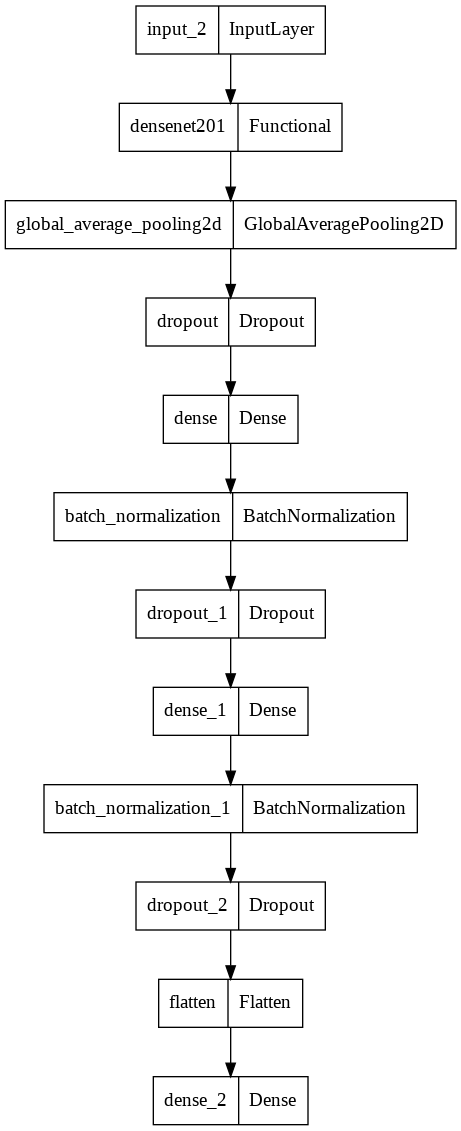

In [ ]:
# '''
pretrained_model = build_pretained_model(model_name = model_name)
pretrained_model.trainable = False
        
# Plug the pre-trained model to custom model
print(f"Plugging in the pretainined model for {model_name} to custom model")
try:
    del model
except:
    None
input_shape = (image_size, image_size, 3)
inputs = tf.keras.Input(input_shape)
m2 = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model(inputs))
m2 = tf.keras.layers.Dropout(dropout_rate)(m2)

m2 = tf.keras.layers.Dense(512, activation = 'relu')(m2)
m2 = tf.keras.layers.BatchNormalization()(m2)
m2 = tf.keras.layers.Dropout(dropout_rate)(m2)

m2 = tf.keras.layers.Dense(256, activation = 'relu')(m2)
m2 = tf.keras.layers.BatchNormalization()(m2)
m2 = tf.keras.layers.Dropout(dropout_rate)(m2)

m2 = tf.keras.layers.Flatten()(m2)

m2 = tf.keras.layers.Dense(2, activation = 'softmax')(m2)

model = tf.keras.Model(inputs = inputs, outputs = m2)

tf.keras.utils.plot_model(model)
# '''

In [ ]:
image_processing_train_path = '/content/image_processing/train'
image_processing_validation_path = '/content/image_processing/val'
image_processing_test_path = '/content/image_processing/test'

In [ ]:
def plot_model_accuracy_and_loss(history, model_name):
   """
   This method plots model training and validation accuracies.
   """
   tf.keras.backend.clear_session()

   hist = history.history
   x_arr = np.arange(len(hist['loss'])) + 1
        
   fig = plt.figure(figsize=(12, 4))
   ax = fig.add_subplot(1, 2, 1)
   ax.plot(x_arr, hist['loss'], '-o', label = 'Train loss')
   ax.plot(x_arr, hist['val_loss'], '--<', label = 'Validation loss')
   ax.legend(fontsize=15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Loss', size = 15)

   ax = fig.add_subplot(1, 2, 2)
   ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train acc.')
   ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Validation acc.')
   ax.legend(fontsize = 15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Accuracy', size = 15)
   ax.set_ylim(0,1)
   plt.title(f"Training and validation loss and accuracies for model : {model_name}")
   plt.show(block = False)

In [ ]:
random_state = 1234

Found 797 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Compiling the model...
Model fit...
Epoch 1/10
25/25 [==============================] - 29s 526ms/step - loss: 1.3130 - accuracy: 0.5307 - val_loss: 0.6551 - val_accuracy: 0.6244
Epoch 2/10
25/25 [==============================] - 8s 313ms/step - loss: 1.1205 - accuracy: 0.5822 - val_loss: 0.6957 - val_accuracy: 0.6091
Epoch 3/10
25/25 [==============================] - 6s 260ms/step - loss: 1.0388 - accuracy: 0.5997 - val_loss: 0.6538 - val_accuracy: 0.6447
Epoch 4/10
25/25 [==============================] - 6s 257ms/step - loss: 1.0621 - accuracy: 0.5696 - val_loss: 0.6656 - val_accuracy: 0.6193
Epoch 5/10
25/25 [==============================] - 6s 255ms/step - loss: 0.8996 - accuracy: 0.6023 - val_loss: 0.6307 - val_accuracy: 0.6751
Epoch 6/10
25/25 [==============================] - 6s 255ms/step - loss: 0.9670 - accuracy: 0.5721 - val_loss: 0.6279 - val_accur

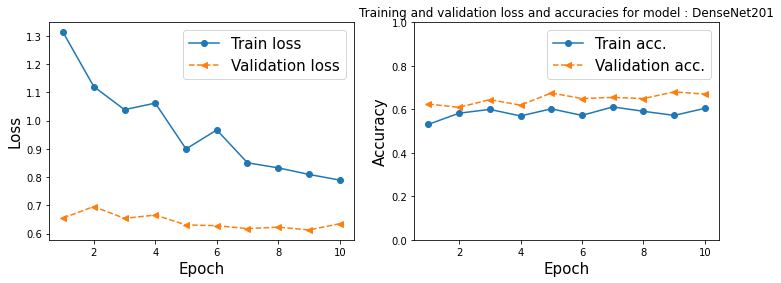

7/7 [==============================] - 5s 292ms/step


In [ ]:
train_dataset_from_data_generator = train_datagen.flow_from_directory(image_processing_train_path,
                                                                     target_size = (image_size, image_size),
                                                                    #  class_mode = 'binary',
                                                                     class_mode = 'categorical',
                                                                     batch_size = batch_size,
                                                                     color_mode = 'rgb',
                                                                     shuffle = True,
                                                                     seed = random_state
                                                                    )
validation_dataset_from_data_generator = val_datagen.flow_from_directory(image_processing_validation_path,
                                                                 target_size = (image_size, image_size),
                                                                #  class_mode = 'binary',
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 color_mode = 'rgb',
                                                                 shuffle = True,
                                                                 seed = random_state
                                                                )
test_dataset_from_data_generator = test_datagen.flow_from_directory(image_processing_test_path,
                                                                   target_size = (image_size, image_size),
                                                                   batch_size = batch_size,
                                                                  #  class_mode = 'binary',
                                                                   class_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   shuffle = False,
                                                                   seed = random_state
                                                                  )
        
tf.random.set_seed(random_state)
np.random.seed(random_state)

# Model compile
print("Compiling the model...")
# model_cnn_5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_val),
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_val),
              # loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy']) 

# Model fit
print("Model fit...")
# history = model_cnn_5.fit(train_dataset_from_data_generator,
history = model.fit(train_dataset_from_data_generator,
                    epochs = epochs,
                    steps_per_epoch = len(train_dataset_from_data_generator),
                    validation_data = validation_dataset_from_data_generator,
                    validation_steps = len(validation_dataset_from_data_generator),
                    verbose = 1
                   )

# Model save
print("Saving model...")
tf.keras.backend.clear_session()
gc.collect()
# model_cnn_5.save('breast_cancer_detection_' + model_name + '.h5')
model.save('breast_cancer_detection_' + model_name + '.h5')

# Plot train and val accuracy and loss
print(f"Plotting train and validation accuracy and loss for model {model_name}")
plot_model_accuracy_and_loss(history = history, model_name = model_name)

# Model Predict, transform logits to probabilities
step_size_test = np.ceil(test_dataset_from_data_generator.n / test_dataset_from_data_generator.batch_size)
test_dataset_from_data_generator.reset()
# pred_logits = model_cnn_5.predict(test_dataset_from_data_generator, steps = step_size_test, verbose = 1)
pred_logits = model.predict(test_dataset_from_data_generator, steps = step_size_test, verbose = 1)
probas_sigmoid = tf.sigmoid(pred_logits)
probas_sigmoid = probas_sigmoid.numpy().flatten() * 100
predictions_binary = [1 if x > 50.0 else 0 for x in probas_sigmoid]


In [ ]:
# test_loss, test_accuracy = model_cnn_5.evaluate(test_dataset_from_data_generator, verbose = 0)
test_loss, test_accuracy = model.evaluate(test_dataset_from_data_generator, verbose = 0)
print(f'test_loss = {round(test_loss, 2)}\ntest_accuracy = {round(test_accuracy, 2)}')
# print(test_loss, test_accuracy)

test_loss = 0.59
test_accuracy = 0.7


In [ ]:
# sample_size = 80000
# sample_size = 40000
# #batch_size = 256
# batch_size = 128
# epochs = 30
# lr_val = 0.01

# image_size = 50
# #number_of_splits = 8
# number_of_splits = 8
# run_mode = ['interim_test', 'final_test']

# # Transfer learning model list
# transfer_learning_model_list = ['VGG16', 
#                                 'VGG19', 
#                                 'DenseNet201', 
#                                 'InceptionV3', 
#                                 'ResNet50', 
#                                 'EfficientNetB7', 
#                                 'MobileNet', 
#                                 'Xception'
#                                ]
# learning_rate_list = [.01, .001, .0001, .00001]
# optimizer_list = ['sgd', 'adam']
# dropout_list = [.2, .4, .6]
# kernel_size_list = [(3,3), (4,4), (5,5)]
# dense_layer_node_list = [512, 256, 128]
# fully_conneted_layer_list = [1, 2, 3]
# epoch_list = [5, 10, 15, 20]

In [ ]:


# # Stores each model and kfold specific train and validation accuracies 
# # and losses for each epoch
# temp_df_model_kpi = pd.DataFrame()
# # Consolidates the above results across all model and kfolds.
# consolidated_df_model_kpi = pd.DataFrame()

# # Holds model and kfold specific actual, prediction %, perdiction binary value
# # along with test loss and accuracy.
# temp_df_acttual_vs_pred_bin_pred_pct = pd.DataFrame()
# # Consolidates the above result for each model and kfold.
# df_actual_vs_pred_bin_pred_pct = pd.DataFrame()

# df_kfold_ensemble_stats = pd.DataFrame()

# for model_name in transfer_learning_model_list:

#     temp_df_model_kpi = pd.DataFrame()
#     temp_df_acttual_vs_pred_bin_pred_pct = pd.DataFrame()
#     for kfold, (train_indices, validation_indices) in enumerate(StratifiedKFold(n_splits =  number_of_splits, 
#                                                                                 shuffle = True, 
#                                                                                 random_state = random_state
#                                                                                ).split(data_proc.df_train_original['label'].values.tolist(), 
#                                                                                        data_proc.df_train_original['label'].values.tolist()
#                                                                                       )):
#         print(f"Model : {model_name}, k-fold : {kfold + 1}, length of train data : {len(train_indices)}, length of validation data : {len(validation_indices)}")
#         data_proc.split_data_based_on_indices(train_indices = train_indices, validation_indices = validation_indices)

#         train_dataset_from_data_generator = train_datagen.flow_from_directory(image_processing_train_path,
#                                                                      target_size = (image_size, image_size),
#                                                                      class_mode = 'binary',
#                                                                      batch_size = batch_size,
#                                                                      color_mode = 'rgb',
#                                                                      shuffle = True,
#                                                                      seed = random_state
#                                                                     )
#         validation_dataset_from_data_generator = val_datagen.flow_from_directory(image_processing_validation_path,
#                                                                  target_size = (image_size, image_size),
#                                                                  class_mode = 'binary',
#                                                                  batch_size = batch_size,
#                                                                  color_mode = 'rgb',
#                                                                  shuffle = True,
#                                                                  seed = random_state
#                                                                 )
#         test_dataset_from_data_generator = test_datagen.flow_from_directory(image_processing_test_path,
#                                                                    target_size = (image_size, image_size),
#                                                                    batch_size = batch_size,
#                                                                    class_mode = 'binary',
#                                                                    color_mode = 'rgb',
#                                                                    shuffle = False,
#                                                                    seed = random_state
#                                                                   )
        
#         tf.random.set_seed(random_state)
#         np.random.seed(random_state)

#         # Pre-trained model build
#         print(f"Building pretainined model for {model_name}")
#         try:
#             del pretrained_model
#         except:
#             None
#         pretrained_model = model_proc.build_pretained_model(model_name = model_name)
#         pretrained_model.trainable = False
#         model_proc.model_summary_and_display_structure(pretrained_model)
        
#         # Plug the pre-trained model to custom model
#         print(f"Plugging in the pretainined model for {model_name} to custom model")
#         try:
#             del model
#         except:
#             None
#         input_shape = (image_size, image_size, 3)
#         inputs = tf.keras.Input(input_shape)
#         m2 = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model(inputs))
#         m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
#         m2 = tf.keras.layers.Dense(512, activation = 'relu')(m2)
#         m2 = tf.keras.layers.BatchNormalization()(m2)
#         m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
#         m2 = tf.keras.layers.Dense(256, activation = 'relu')(m2)
#         m2 = tf.keras.layers.BatchNormalization()(m2)
#         m2 = tf.keras.layers.Dropout(dropout_rate)(m2)
#         m2 = tf.keras.layers.Flatten()(m2)
#         m2 = tf.keras.layers.Dense(1, activation = None)(m2)
#         model = tf.keras.Model(inputs = inputs, outputs = m2)
#         # Model compile
#         print("Compiling the model...")
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_val),
#                       loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
#                       metrics = ['accuracy']) 

#         # Model fit
#         print("Model fit...")
#         #es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, min_delta = 1)
#         history = model.fit(train_dataset_from_data_generator,
#                             epochs = epochs,
#                             steps_per_epoch = len(train_dataset_from_data_generator),
#                             validation_data = validation_dataset_from_data_generator,
#                             validation_steps = len(validation_dataset_from_data_generator),
#                             verbose = 1
#                            )

#         # Model save
#         print("Saving model...")
#         tf.keras.backend.clear_session()
#         gc.collect()
#         model.save('tumor_detection_' + model_name + '_k' + str(kfold + 1) + '.h5')
#         #tf.saved_model.save(model, os.getcwd())
#         saved_model_names_list.append('tumor_detection_' + model_name + '_k' + str(kfold + 1))
        
#         # Append the final train and validation accuracy and loss.
#         print(f"Storing train and validation accuracy and loss for model {model_name}, fold {kfold + 1}")
#         temp_df_model_kpi = pd.DataFrame(history.history)
#         temp_df_model_kpi['model'] = model_name
#         temp_df_model_kpi['kfold'] = kfold + 1
#         temp_df_model_kpi['epoch'] = range(1, epochs + 1)
#         temp_df_model_kpi = temp_df_model_kpi[['model', 
#                                                'kfold', 
#                                                'epoch', 
#                                                'accuracy', 
#                                                'loss', 
#                                                'val_accuracy', 
#                                                'val_loss'
#                                                ]]
#         # Consolidating training and validation accuracies in single data frame 
#         # along with model name, epoch, kfold number.
#         consolidated_df_model_kpi = pd.concat([temp_df_model_kpi, consolidated_df_model_kpi], axis = 0)
        
#         # Plot train and val accuracy and loss
#         print(f"Plotting train and validation accuracy and loss for model {model_name}, fold {kfold + 1}")
#         model_proc.plot_model_accuracy_and_loss(history = history, model_name = model_name)

#         # Model Predict, transform logits to probabilities
#         step_size_test = np.ceil(test_dataset_from_data_generator.n / test_dataset_from_data_generator.batch_size)
#         test_dataset_from_data_generator.reset()
#         pred_logits = model.predict(test_dataset_from_data_generator, steps = step_size_test, verbose = 1)
#         probas_sigmoid = tf.sigmoid(pred_logits)
#         probas_sigmoid = probas_sigmoid.numpy().flatten() * 100
#         predictions_binary = [1 if x > 50.0 else 0 for x in probas_sigmoid]
#         test_loss, test_accuracy = model.evaluate(test_dataset_from_data_generator, verbose = 0)

#         temp_df_actual_vs_pred_bin_pred_pct = pd.DataFrame({"model"         : model_name, 
#                                                             "kfold"         : kfold + 1, 
#                                                             "actual"        : data_proc.y_test, 
#                                                             "pred_pct"      : probas_sigmoid, 
#                                                             "pred_bin"      : predictions_binary,
#                                                             "test_loss"     : test_loss,
#                                                             "test_accuracy" : test_accuracy
#                                                            }
#                                                           )
#         # Assign the index value of the index position
#         temp_df_actual_vs_pred_bin_pred_pct['output_pos'] = temp_df_actual_vs_pred_bin_pred_pct.groupby(['model','kfold']).cumcount() + 1
#         df_actual_vs_pred_bin_pred_pct = pd.concat([temp_df_actual_vs_pred_bin_pred_pct, 
#                                                     df_actual_vs_pred_bin_pred_pct
#                                                    ], 
#                                                    axis = 0)
    
#     # Summary stats across all folds for a model
#     model_proc.display_model_stats_across_all_spilts(model_name, 
#                                                      consolidated_df_model_kpi, 
#                                                      df_actual_vs_pred_bin_pred_pct
#                                                     )
    
#     # voting across model, kfold
#     print(f"Calling ensemble_across_model_kfolds for model {model_name}")
#     temp_df_kfold_ensemble_stats = model_proc.ensemble_across_model_kfolds(df_actual_vs_pred_bin_pred_pct[df_actual_vs_pred_bin_pred_pct.model == model_name])

#     # Appending the result back
#     df_kfold_ensemble_stats = pd.concat([temp_df_kfold_ensemble_stats, 
#                                          df_kfold_ensemble_stats
#                                         ],
#                                         axis = 0)

# # voting across model, kfold
# print(f"Calling ensemble_across_models")
# df_ensemble_stats = model_proc.ensemble_across_models(df_kfold_ensemble_stats)
